In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(pbapply)
pboptions(type="timer")

Loading required package: cowplot

Loading required package: data.table

Loading required package: ggplot2

Loading required package: pbapply



### Read input region metadata.

In [7]:
probe_meta = fread("data/rois/all_regions.tsv")
probe_summary = fread("data/probe_summary_probelet.tsv")    # data/probe_summary.csv
probelist = list.files("data/", recursive=TRUE, pattern="probe_.+oligos\\.tsv$")

current_region = 1

current_probe_id = 1

probe = fread(paste("data",probelist[current_probe_id],sep="/"))

probelist[current_probe_id]
head(probe)

[1] "query_output_t_20220831-110654_p_1E-4(4000oligos)/probe_roi_1.4000oligos.tsv"

name,chromosome,start,end,sequence,gc_content,off_target_no,Tm_dG,Tm_dH,Tm_dS,Tm,ss_dG,oligo_cost
<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ROI_1,chr17,39484766,39484846,CATGATACTCAAAGGAAATGCTCATTGGAGCATTTCAGTATTCAGATTTTTGCATTGAATATGCTCATCCAGTATAATGC,0.3500,38,-96.71381,-634.7,-1.7346,81.05720,-12.321,0.44406316
ROI_1,chr17,39484851,39484931,ATCCAAAATCTAAAAATTTTAAAAATTTGAAACACTCAGGCCGGGTGCGGTGGCTCACGCCTGTAATCCCAGAACTTTGG,0.4250,47,-104.97640,-643.8,-1.7373,85.64334,-7.242,0.46065360
ROI_1,chr17,39485181,39485261,AAAAAAAAGTTCAGACACTCTGGTTTGAGGCATTGTGGATAAGAGAGTACCTAATCTGTATTAGTACTTTATTTGAGCTC,0.3500,0,-95.39069,-629.5,-1.7221,80.61607,-3.896,0.04084256
ROI_1,chr17,39485266,39485346,GTAAACATTGGAGAAAACAAAAATATGAAACACAGATTGGCTGGGCATGGTGGCTGATGCCTGTGATCCCAGCACTTTAG,0.4375,50,-104.72076,-642.8,-1.7349,85.56190,-9.242,0.50492042
ROI_1,chr17,39485432,39485512,GGAAACAGAGTCTCACTCTGTCGCCAGGCTGGAGTGCAGTGGCTCAATCTCAGCTCACTAATCTCCACCTCCCGGGTTCA,0.5625,60,-113.37208,-650.8,-1.7328,90.49281,-10.718,0.59453827
ROI_1,chr17,39485517,39485597,TTCCCCTGCCTCAGCCTCCTGAGTAGCTGGGACTAACAGGCGGGTGCCACCACGCCTGGCTAATTTTTTTTGTATTTTGG,0.5375,45,-112.75704,-648.2,-1.7264,90.34307,-15.148,0.50934194


In [8]:
probe_meta[current_region]
#probe_summary[, region_start := probe_meta[current_region, DNA_start], region_end := probe_meta[current_region, DNA_end]]

Window_start,Window_end,window_id,chrom,DNA_start,DNA_end,window,type,ref,length,Gene_start,Gene_end,Gene_strand,Gene_name,Gene_id,design_type
<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>
39462072,39917316,1,chr17,39462072,39917316,4000,targets,Homo_sapiens.GRCh38.dna,80,NA,NA,NA,NA,NA,DNA


### Evaluate oligo distribution homogeneity

In [9]:

probe[, homogeneity := 1 / sd(start[2:.N] - end[1:(.N-1)])]
probe[, summary(homogeneity)]
probe[, Tm_range := diff(range(Tm))]
probe[, summary(Tm_range)]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01965 0.01965 0.01965 0.01965 0.01965 0.01965 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  26.04   26.04   26.04   26.04   26.04   26.04 

### Visualize current probe and feature stats

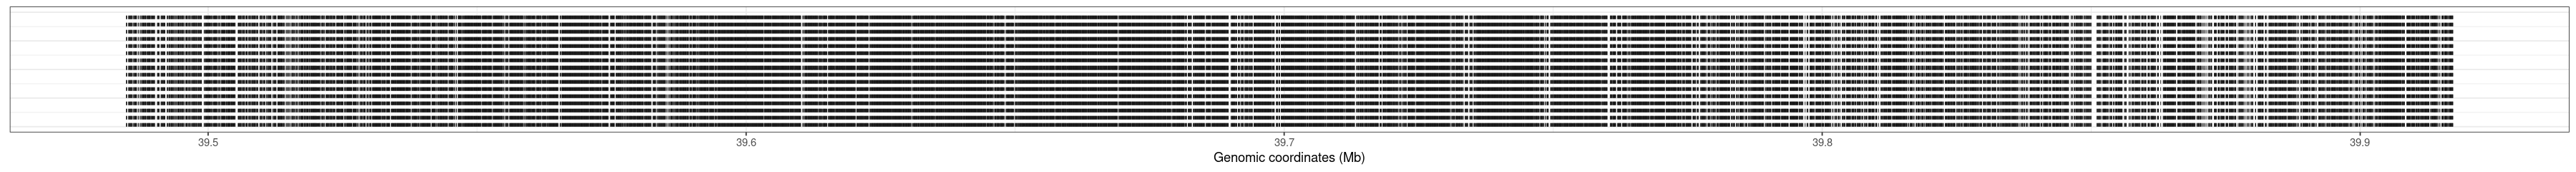

In [10]:
options(repr.plot.width=30, repr.plot.height=2)
ggplot(probe, aes(x=start/1e6, xend=end/1e6, y=1, yend=1)) + geom_segment() +
    theme_bw() + labs(x="Genomic coordinates (Mb)") + theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank()) +
    geom_segment(aes(x=(start+end)/2e6, xend=(start+end)/2e6, y=.9, yend=1.1), linetype="dashed", size=.25)

[1] "Stats for Tm"
[1] "Tm range: 26.675120"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  65.09   68.52   70.33   71.15   73.10   91.76 

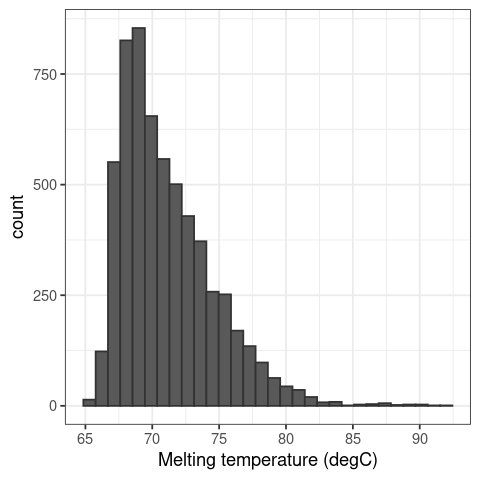

In [24]:
print("Stats for Tm")
print(sprintf("Tm range: %f", probe[, Tm_range[1]]))
probe[, summary(Tm)]
options(repr.plot.width=4, repr.plot.height=4)
ggplot(probe, aes(x=Tm)) + geom_histogram(bins=30, color="#323232") + labs(x="Melting temperature (degC)") + theme_bw()

[1] "Stats for distance between consecutive oligos"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    5.0    13.0    28.0    40.2    50.5   447.0 

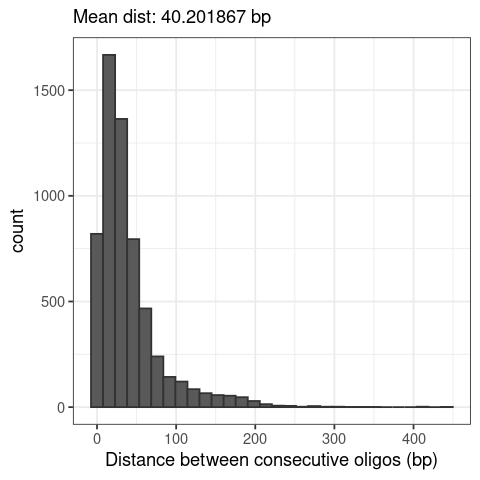

In [25]:
print("Stats for distance between consecutive oligos")
probe[, summary(start[2:.N]-end[1:(.N-1)])]
options(repr.plot.width=4, repr.plot.height=4)
ggplot(probe[, .(odist=start[2:.N]-end[1:(.N-1)])]) + geom_histogram(aes(x=odist), color="#323232", bins=30) +
    labs(x="Distance between consecutive oligos (bp)", subtitle=sprintf("Mean dist: %f bp", probe[, mean(start[2:.N]-end[1:(.N-1)])])) + theme_bw()

In [26]:
print("Stats for off_targets")
probe[, summary(offtargets_no)]
probe[, .N, by=offtargets_no][order(offtargets_no)]

[1] "Stats for off_targets"


ERROR: Error in summary(offtargets_no): object 'offtargets_no' not found
